<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/4_xr_Annotations_classification_BBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

Create data frame of annotation info

In [12]:
features_path = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_features_full_pain.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1078, 13)
Int64Index([], dtype='int64')
(1078, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,A2,D2,32692.5,BBC,33001.680,0.278688,35066.527850,44975.041894,2.700772,6.672909,-0.001613,33313.201458
1,1,A2,D2,97515.0,BBC,42889.350,0.209728,33325.032145,64997.459077,2.717043,6.765939,-0.002337,31658.780537
2,2,A2,D2,124942.5,BBC,32306.705,0.250006,30640.698606,49617.524980,2.513463,5.396313,-0.002205,29108.663676
3,3,A2,D2,292027.5,BBC,128251.040,0.089902,37497.496525,201737.430661,3.751878,12.999226,-0.002475,35622.621699
4,4,A2,D2,296505.0,BBC,65412.070,0.180102,35595.230449,62452.123418,3.204285,11.323622,-0.002025,33815.468927


In [13]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                       power_sum                                                                                          spec_cent                                                                                                  spec_kurt                                                                           spec_pur                                                                       spec_roll                                                                                                  spec_skew                                                                       spec_slope                                                                       spec_spread                                                                                                   time_stamp                                                                                 
                count   mean         std  min     25%    50%     75%    max     count          mean            std        min          25%         50%         75%         max     count          mean          std           min           25%           50%           75%           max     count       mean       std       min       25%        50%        75%        max    count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max     count      mean       std       min       25%       50%       75%       max      count      mean       std       min       25%       50%       75%       max       count          mean           std          min           25%           50%           75%            max      count           mean           std     min        25%        50%         75%       max
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
BBC             178.0   88.5   51.528309  0.0   44.25   88.5  132.75  177.0     178.0  50731.051506   41822.825325  15415.630  29378.28900  34589.3515  55584.9175   350587.62     178.0  33049.863884  5112.292861  19510.444892  29884.997728  32954.555754  36011.021083  49536.698653     178.0  14.687762  9.491488 -0.118863  7.220186  12.647498  19.512482  42.441590    178.0  0.239406  0.076033  0.055395  0.190478  0.250679  0.288418  0.452791     178.0  31397.370690  4856.678218  18534.922647  28390.747842  31306.827966  34210.470029  47059.863720     178.0  3.554693  1.131336  0.169895  2.722355  3.481161  4.305429  6.360582      178.0 -0.001875  0.000578 -0.002788 -0.002163 -0.001973 -0.001721  0.001387       178.0  73138.833768  48864.970569  6206.632577  40404.321256  64707.748995  93492.256546  348444.606763      178.0  131690.477528  91159.682643  1327.5  45810.000  119362.50  200953.125  297652.5
rand_noise      900.0  449.5  259.951919  0.0  224.75  449.5  674.25  899.0     900.0  33787.308716  130512.857831  13971.504  16483.41675  18665.3250  24040.5795  3630241.00     900.0  39839.066306  8529.911658  12424.908990  35157.421216  42317.703466  46330.710954  53341.008861     900.0   4.317991  6.610617 -0.687714  0.552061   1.573492   4.867

In [14]:
annot_features_bbc = annot_features_full[(annot_features_full['Annotation'] == 'BBC') | (annot_features_full['Annotation'] == 'rand_noise')]
print(annot_features_bbc.shape)
annot_features_bbc.head()

(1078, 13)


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,A2,D2,32692.5,BBC,33001.680,0.278688,35066.527850,44975.041894,2.700772,6.672909,-0.001613,33313.201458
1,1,A2,D2,97515.0,BBC,42889.350,0.209728,33325.032145,64997.459077,2.717043,6.765939,-0.002337,31658.780537
2,2,A2,D2,124942.5,BBC,32306.705,0.250006,30640.698606,49617.524980,2.513463,5.396313,-0.002205,29108.663676
3,3,A2,D2,292027.5,BBC,128251.040,0.089902,37497.496525,201737.430661,3.751878,12.999226,-0.002475,35622.621699
4,4,A2,D2,296505.0,BBC,65412.070,0.180102,35595.230449,62452.123418,3.204285,11.323622,-0.002025,33815.468927


In [0]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_bbc, test_size=0.3, random_state=1, stratify = annot_features_bbc.Annotation)

In [16]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

rand_noise    629
BBC           629
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
78,78,A6,D3,162517.5,BBC,68156.440,0.187200,31514.690472,85639.593214,3.589622,12.904453,-0.002214,29938.955948
124,124,A12,D3,152032.5,BBC,27928.262,0.304314,39094.049942,173179.208219,5.095447,26.057127,-0.001720,37139.347444
62,62,A4,D3,185287.5,BBC,81081.190,0.189197,31584.553143,93767.091005,6.058342,41.135769,-0.002127,30005.325486
70,70,A4,D3,296685.0,BBC,80507.370,0.111275,30258.227260,121942.846727,4.239221,18.490913,-0.002610,28745.315897
154,154,A10,D4,242347.5,BBC,77760.880,0.146432,24225.699985,20037.851443,2.133710,4.169034,-0.001984,23014.414986


In [0]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up = annot_labels_up.replace(regex={r'BBC': 1, 'rand_noise': 0})

In [18]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
78,68156.440,0.187200,31514.690472,85639.593214,3.589622,12.904453,-0.002214,29938.955948
124,27928.262,0.304314,39094.049942,173179.208219,5.095447,26.057127,-0.001720,37139.347444
62,81081.190,0.189197,31584.553143,93767.091005,6.058342,41.135769,-0.002127,30005.325486
70,80507.370,0.111275,30258.227260,121942.846727,4.239221,18.490913,-0.002610,28745.315897
154,77760.880,0.146432,24225.699985,20037.851443,2.133710,4.169034,-0.001984,23014.414986


In [0]:
#group_k_fold = GroupKFold(n_splits=3)
#cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

skf = StratifiedKFold(n_splits=3)
cv = list(skf.split(annot_features_up, annot_labels_up))

In [0]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [0]:
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=10, random_state=0)
svm_cv = SVC(probability=True) 

In [30]:
y_pred_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(annot_labels_up, y_pred_lr)
conf_mat_lr

array([[610,  19],
       [ 35, 594]])

In [31]:
y_pred_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(annot_labels_up, y_pred_rf)
conf_mat_rf

array([[625,   4],
       [  1, 628]])

In [32]:
y_pred_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(annot_labels_up, y_pred_svm)
conf_mat_svm

array([[617,  12],
       [ 28, 601]])

In [33]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_lr))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_lr))

Sensitivity/Recall (TPR):  0.9443561208267091
Precision (PPV):  0.9690048939641109
Accuracy:  0.9570747217806042
F1: 0.9565217391304348


In [34]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_rf))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_rf))

Sensitivity/Recall (TPR):  0.9984101748807631
Precision (PPV):  0.9936708860759493
Accuracy:  0.9960254372019078
F1: 0.9960348929421095


In [35]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_svm))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_svm))

Sensitivity/Recall (TPR):  0.9554848966613673
Precision (PPV):  0.9804241435562806
Accuracy:  0.9682034976152624
F1: 0.9677938808373591


In [36]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.9800551510081109
Random forest ROC_AUC:  0.998151101630013
SVM ROC_AUC:  0.991153596315852


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

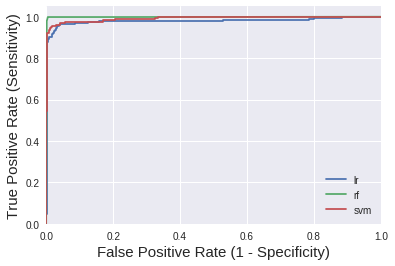

In [37]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(annot_labels_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(annot_labels_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

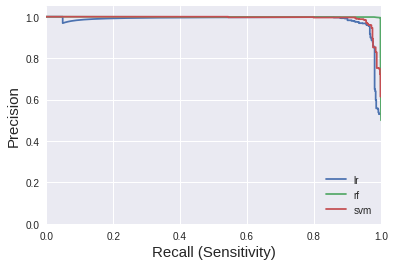

In [38]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

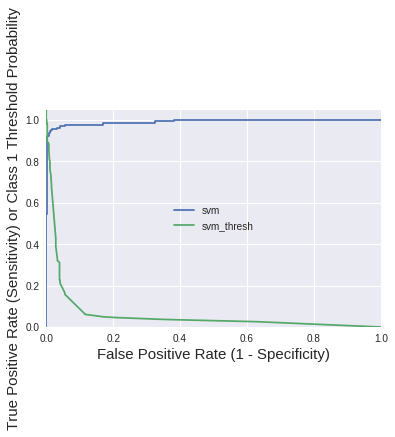

In [39]:
# plot LR and RF model ROC curves
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_svm, thresholds_svm, label="svm_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [64]:
train_orig_upsamples['pred_lr'] = y_pred_prob_lr[:,1]
train_orig_upsamples['pred_rf'] = y_pred_prob_rf[:,1]
train_orig_upsamples['pred_svm'] = y_pred_prob_svm[:,1]
train_orig_upsamples['class_actual'] = annot_labels_up
train_orig_upsamples['class_rf'] = y_pred_rf
train_orig_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf,pred_svm,class_actual,class_svm,pred,class_rf
78,78,A6,D3,162517.5,BBC,68156.440,0.187200,31514.690472,85639.593214,3.589622,12.904453,-0.002214,29938.955948,0.997162,1.0,1.000000,1,1,TP,1
124,124,A12,D3,152032.5,BBC,27928.262,0.304314,39094.049942,173179.208219,5.095447,26.057127,-0.001720,37139.347444,0.999940,1.0,0.990025,1,1,TP,1
62,62,A4,D3,185287.5,BBC,81081.190,0.189197,31584.553143,93767.091005,6.058342,41.135769,-0.002127,30005.325486,0.992930,1.0,0.986789,1,1,TP,1
70,70,A4,D3,296685.0,BBC,80507.370,0.111275,30258.227260,121942.846727,4.239221,18.490913,-0.002610,28745.315897,0.999491,1.0,0.999998,1,1,TP,1
154,154,A10,D4,242347.5,BBC,77760.880,0.146432,24225.699985,20037.851443,2.133710,4.169034,-0.001984,23014.414986,0.672865,0.9,0.974017,1,1,TP,1


In [41]:
train_orig_upsamples.groupby('Annotation')['pred_lr', 'pred_rf', 'pred_svm'].describe()

pred_lr                                                                       pred_rf                                              pred_svm                                                                     
             count      mean       std       min       25%       50%       75%       max   count      mean       std  min  25%  50%  75%  max    count      mean      std       min       25%       50%       75%       max
Annotation                                                                                                                                                                                                                 
BBC          629.0  0.917006  0.197108  0.017567  0.956507  0.992552  0.998425  0.999999   629.0  0.988394  0.057347  0.0  1.0  1.0  1.0  1.0    629.0  0.948882  0.18143  0.026097  0.990684  0.999996  1.000000  1.000000
rand_noise   629.0  0.080775  0.131198  0.002103  0.024016  0.037975  0.069962  0.999925   629.0  0.038951  0.099327  0.0  0.0  0.0  0.0  1.0    629.0  0.058512  0.12171  0.000287  0.020658  0.031090  0.042931  0.999992

In [0]:
preds = []
for index, row in train_orig_upsamples.iterrows():
    if (row['class_actual'] == 0) & (row['class_rf'] == 0):
        pred = 'TN'
    if (row['class_actual'] == 0) & (row['class_rf'] == 1):
        pred = 'FP'
    if (row['class_actual'] == 1) & (row['class_rf'] == 1):
        pred = 'TP'
    if (row['class_actual'] == 1) & (row['class_rf'] == 0):
        pred = 'FN'
    preds.append(pred)
    
train_orig_upsamples['pred'] = preds

In [66]:
train_orig_upsamples.groupby('pred').describe()

Unnamed: 0                                                              class_actual                                    class_rf                                    class_svm                                              power_sum                                                                                         pred_lr                                                                       pred_rf                                                  pred_svm                                                                       spec_cent                                                                                                  spec_kurt                                                                             spec_pur                                                                       spec_roll                                                                                                  spec_skew                                                                        \
          count        mean         std    min     25%    50%     75%    max        count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max     count      mean       std  min  25%  50%  75%  max     count          mean           std        min         25%         50%          75%         max   count      mean       std       min       25%       50%       75%       max   count      mean       std  min    25%   50%   75%  max    count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max     count       mean        std       min        25%        50%        75%        max    count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max     count      mean       std       min       25%       50%       75%       max   
pred                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
FN          1.0   77.000000         NaN   77.0   77.00   77.0   77.00   77.0          1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0      1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0       1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0       1.0  18059.482000           NaN  18059.482  18059.4820  18059.4820  18059.48200   18059.482     1.0  0.019147       NaN  0.019147  0.019147  0.019147  0.019147  0.019147     1.0  0.000000       NaN  0.0  0.000  0.00  0.00  0.0      1.0  0.026097       NaN  0.026097  0.026097  0.026097  0.026097  0.026097       1.0  45573.149515          NaN  45573.149515  45573.149515  45573.149515  45573.149515  45573.149515       1.0   1.769986        NaN  1.769986   1.769986   1.769986   1.769986   1.769986      1.0  0.428912       NaN  0.428912  0.428912  0.428912  0.428912  0.428912       1.0  43294.492040          NaN  43294.492040  43294.492040  43294.492040  43294.492040  43294.492040       1.0  0.861732       NaN  0.861732  0.861732  0.861732  0.861732  0.861732   
FP          4

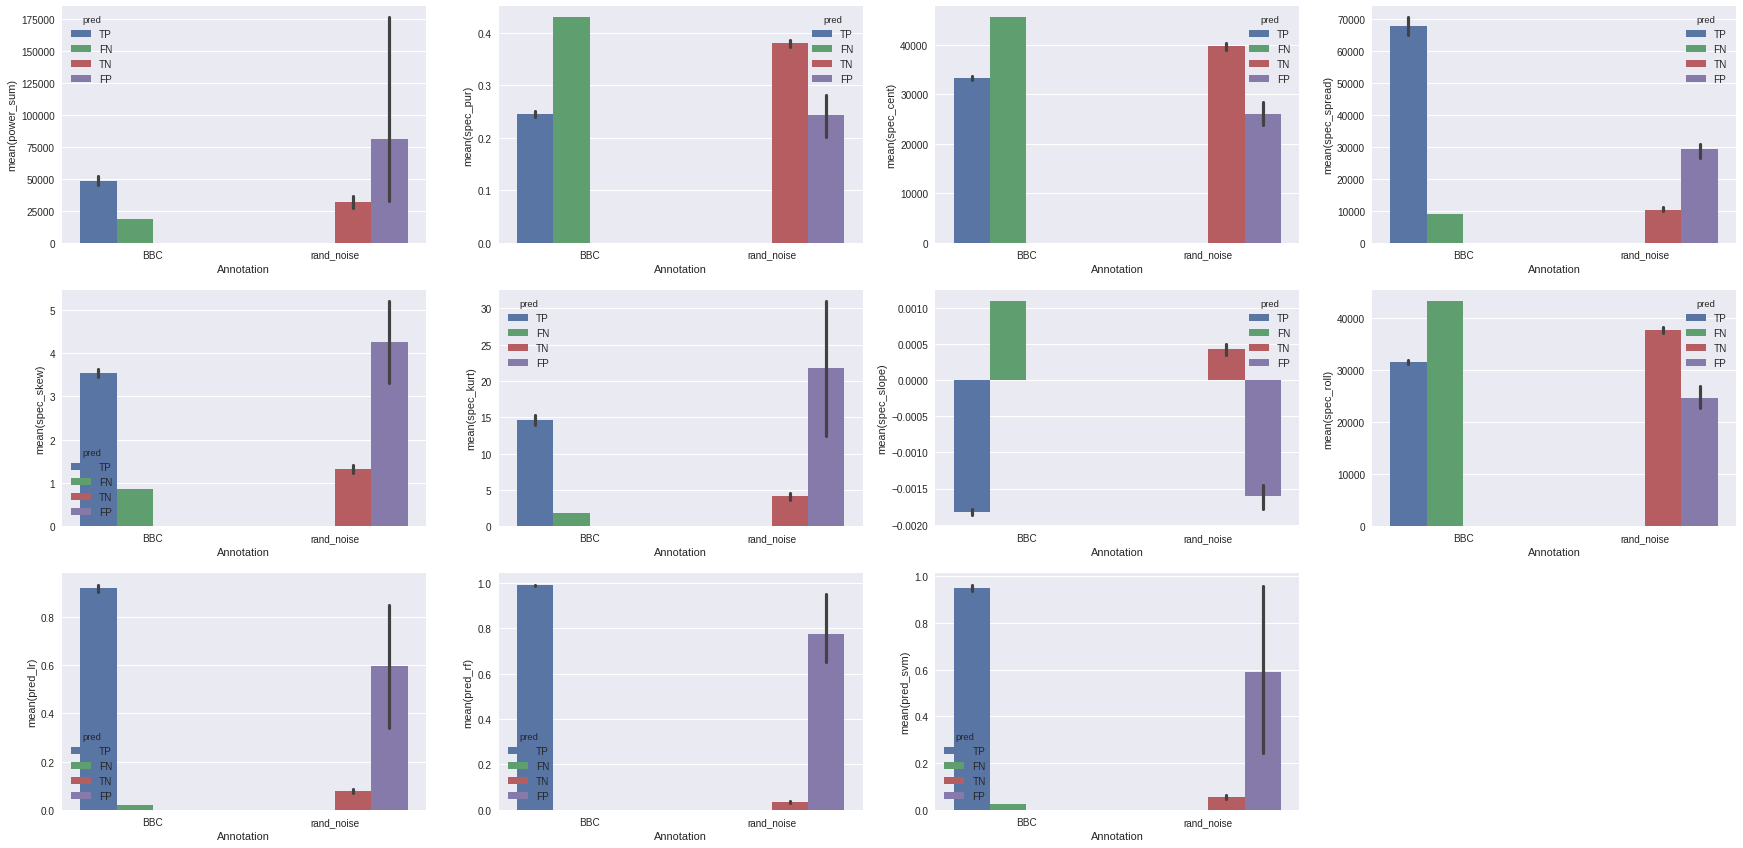

In [67]:
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_lr', 'pred_rf',
       'pred_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_orig_upsamples)
    i = i + 1

In [69]:
false_neg_unique

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf,pred_svm,class_actual,class_svm,pred,class_rf
77,77,A6,D3,111307.5,BBC,18059.482,0.428912,45573.149515,9067.449981,0.861732,1.769986,0.001107,43294.49204,0.019147,0.0,0.026097,1,0,FN,0


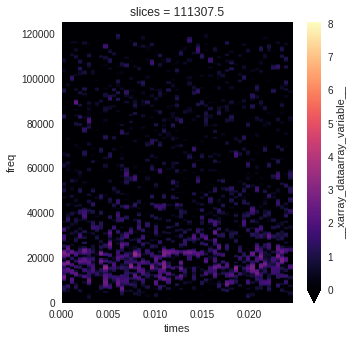

In [68]:
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_neg_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FN'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(5, 5, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

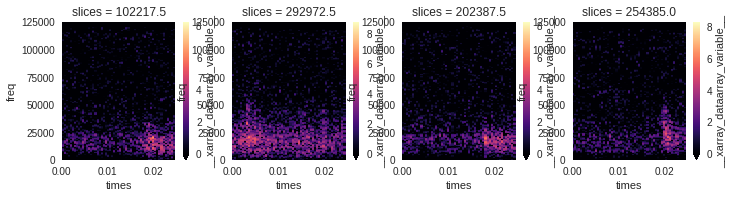

In [70]:
false_pos_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FP'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(10, 10, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1